# Обработка текста при помощи TensorFlow

Лекцию подготовил студент группы 6133-010402D Мелешенко Иван

# Кто этот ваш такой TensorFlow, когда он появился и для чего он нужен?

Согласно определения c официального [репозиотрия TensorFlow](https://github.com/tensorflow/tensorflow):

`"TensorFlow - это сквозная платформа с открытым исходным кодом для машинного обучения. Она имеет всеобъемлющую, гибкую экосистему инструментов, библиотеки ресурсов сообщества, которая позволяет исследователям внедрять новейшие технологии в области ML, а разработчикам легко создавать и развертывать приложения на базе ML."`

TensorFlow 9 ноября 2015 года был открыт для свободного доступа. TensorFlow может работать на многих параллельных процессорах, как CPU, так и GPU, опираясь на архитектуру CUDA для поддержки вычислений общего назначения на графических процессорах.

# Инструменты обработки текста для TensorFlow

TensorFlow предоставляет богатую коллекцию операций и библиотек, которые помогут работать с вводом в текстовой форме, такой как необработанные текстовые строки или документы. Эти библиотеки могут выполнять предварительную обработку, обычно необходимую для текстовых моделей, и включают в себя другие функции, полезные для моделирования последовательностей.

TensorFlow позволяет извлекать мощные синтаксические и семантические функции текста из графа TensorFlow в качестве входных данных для нейронной сети.

Интеграция предварительной обработки с графом TensorFlow дает следующие преимущества:

* Облегчает большой набор инструментов для работы с текстом
* Обеспечивает интеграцию с большим набором инструментов Tensorflow для поддержки проектов от определения проблемы до обучения, оценки и запуска.
* Снижает сложность подачи времени и предотвращает перекос между обучением и обслуживанием.

В дополнение к вышесказанному нет необходимости беспокоиться о том, что токенизация при обучении отличается от токенизации при выводе или управлении сценариями предварительной обработки.

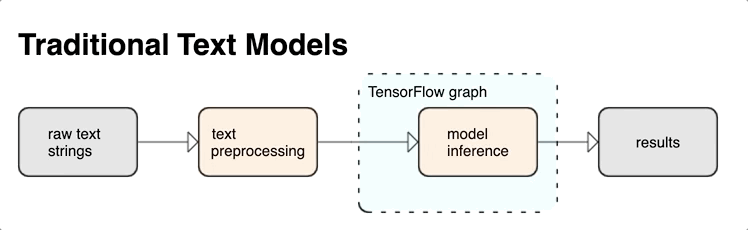

# Возможности TensorFlow по работе с текстом

* Предварительная обработка текста
    + Сквозная предварительная обработка
    + Токенизация подслов
* Текстовая классификация
    + Классификация текстов с помощью BERT
    + Текстовая классификация с RNN
* Генерация текста
    + Перевод текста с моделями-трансформерами
    + Перевод текста с моделями seq2seq

# Текстовая классификация при помощи модели BERT

## Классификация текста при помощи модели BERT

В данной части лекции, рассмотрим код для точной настройки модели BERT для выполнения анализа настроений на наборе данных обычных текстовых обзоров фильмов IMDB. В дополнение к настройке модели рассмотрим, как предварительно необходимо обработать текст в соответствующем формате.

Классификация текста при помощи модели BERT, предусматривает

- Загрузку набора данных IMDB
- Загрузку модели BERT из TensorFlow Hub
- Создание своей собственной модели, объединением BERT с классификатором
- Обучение собственной модели, посредством отладки BERT
- Сохранение модели и использование ее для классификации предложений

## О BERT

BERT и другие архитектуры кодировщика Transformer оказались чрезвычайно успешными в различных задачах NLP (обработка естественного языка). Они вычисляют представления естественного языка в векторном пространстве, которые подходят для использования в моделях глубокого обучения. Семейство моделей BERT использует архитектуру кодировщика Transformer для обработки каждого маркера входного текста в полном контексте всех маркеров до и после, отсюда и название: представления двунаправленного кодировщика от Transformers.

Модели BERT обычно предварительно обучаются на большом массиве текстов, а затем настраиваются для конкретных задач.

## Установка и настройка TensorFlow


In [ ]:
# Зависимость предварительной обработки для входных данных BERT
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 33.2 MB/s 


Будем использовать оптимизатор AdamW из [tensorflow/models](https://github.com/tensorflow/models).

In [ ]:
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 26.3 MB/s 
     |████████████████████████████████| 99 kB 9.5 MB/s 
     |████████████████████████████████| 596 kB 57.1 MB/s 
     |████████████████████████████████| 237 kB 64.3 MB/s 
     |████████████████████████████████| 352 kB 67.3 MB/s 
     |████████████████████████████████| 1.2 MB 50.2 MB/s 
     |████████████████████████████████| 92 kB 12.0 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 48.3 MB 106 kB/s 
     |████████████████████████████████| 1.1 MB 40.5 MB/s 


In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # для использования оптимизатора AdamW

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Анализ настроений


В данной части лекции произведем обучение модели анализа настроений для классификации отзывов о фильмах как *положительных* или *отрицательных* на основе текста рецензии.

Для классификации будем использовать [Большой набор данных обзоров фильмов](https://ai.stanford.edu/~amaas/data/sentiment/), который содержит текст 50 000 обзоров фильмов из [База данных фильмов в Интернете](https://www.imdb.com/).

### Загрузка набора данных IMDB

Произведем загрузку и извлечение набора данных, после чего изучим структуру каталогов.


Для загрузки и промсотра модели воспользуемся библиотекой Keras. Что это такое?<br/>Согласно определения из официального [репозитория Keras](https://github.com/keras-team/keras) :<br/> `"Keras - это API для глубокого обучения, написанный на Python и работающий поверх платформы машинного обучения TensorFlow."`

In [ ]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# для упрощения загрузки данных удалим неиспользуемые папки
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84140032/84125825 [==============================] - 9s 0us/step


Далее воспользуемся утилитой `text_dataset_from_directory`, для создаяни маркированного `tf.data.Dataset`.

Набор данных IMDB уже разделен на обучающий и тестовый, однако в нем отсутствует проверочный набор. Для создания проверочного набора, произведем разделение обучающих данных в следующем процентном соотношении 80:20, используя аргумент `validation_split` ниже.

ВНИМАНИЕ: При использовании аргументов `validation_split` и `subset` необходимо убедиться, в том что либо указано случайное начальное значение, либо передано `shuffle=False`, чтобы разделение проверки и обучения не перекрывалось.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


Предлагаю взглянуть на несколько обзоров.

In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

## Загрузка моделей из TensorFlow Hub

Далее необходимо выбрать модель, которая будет загружена из TensorFlow Hub, для выполнения более точной настройки. Для выбора доступны следующие модели:

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) и [seven more models](https://tfhub.dev/google/collections/bert/1)  тренированными весами, выпущенные авторами оригинального BERT.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) имеют ту же общую архитектуру, но меньший размер и/или меньшее количество блоков Transformer, что позволяет искать компромиссы между скоростью, размером и качеством.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): четыре разных размера «A Lite BERT», которые уменьшают размер модели (но не время вычислений) за счет совместного использования параметров между слоями.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): восемь моделей, каждая из которых имеет базовую архитектуру BERT, но предлагает выбор между различными доменами предварительного обучения, чтобы более точно соответствовать целевой задаче.
  - [Electra](https://tfhub.dev/google/collections/electra/1) имеет ту же архитектуру, что и BERT (в трех разных размерах), но предварительно обучается как дискриминатор в настройке, напоминающей [генеративно-состязательную сеть (GAN)](https://ru.wikipedia.org/wiki/%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%BE-%D1%81%D0%BE%D1%81%D1%82%D1%8F%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C).
  - BERT c Talking-Heads Attention и Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] имеет два улучшения в ядре архитектуры Transformer.

Более подробную информацию о моделях TensorFlow Hub можно получить по следующей ссылке --> [`tfhub.dev`](http://tfhub.dev).

In [ ]:
#@title Выбор лучшей модели для более точной настройки

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## Модель предварительной обработки

Вводимые текстовые данные должны быть преобразованы в числовые идентификаторы токенов и упорядочены в несколько тензоров перед вводом в BERT. TensorFlow Hub предоставляет соответствующую модель предварительной обработки для каждой из рассмотренных выше моделей BERT, которая реализует это преобразование с использованием операций TF из библиотеки TF.text. В этом случае отпадает необходимость в запуске чистого кода Python вне модели TensorFlow для предварительной обработки текста.

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Рассмотрим модель предварительной обработки на некотором тексте и посмотрим на результат:

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


Нетрудно заметить, что мы получаем 3 результата предварительной обработки, которые использовала бы модель BERT (`input_words_id`, `input_mask` и `input_type_ids`).

Отметим несколько важных моментов: 
- Ввод усекается до 128 токенов. Количество токенов можно настроить, и вы можете увидеть более подробную информацию в [Решение задач GLUE с помощью BERT в совместной лаборатории TPU](https://www.tensorflow.org/text/tutorials/bert_glue).
- `input_type_ids` имеет только одно значение (0), потому что это ввод одного предложения. Для ввода нескольких предложений он будет иметь одно число для каждого ввода.

Поскольку этот текстовый препроцессор является моделью TensorFlow, то его можно напрямую включить в нашу модель.

## Использование модели BERT

Перед тем как использовать BERT в собственной модели, необходимо просмотреть результаты. Загрузку можно произвести из TF Hub для того, чтобы увидеть возвращенные значения.

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262903  0.99280983 -0.18611853  0.3667385   0.15233739  0.6550446
  0.9681154  -0.9486271   0.00216157 -0.9877732   0.06842728 -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946295  0.34321263  0.33231527 ...  0.2130087   0.71020836
  -0.05771071]
 [-0.2874208   0.31981027 -0.23018518 ...  0.5845508  -0.21329744
   0.7269212 ]
 [-0.66157013  0.6887687  -0.8743292  ...  0.10877226 -0.26173285
   0.47855547]
 ...
 [-0.22561097 -0.2892568  -0.07064426 ...  0.47566074  0.83277184
   0.40025318]
 [-0.29824227 -0.27473107 -0.05450526 ...  0.488498    1.0955358
   0.18163362]
 [-0.4437815   0.00930744  0.07223801 ...  0.17290124  1.1833242
   0.07898009]]


Модели BERT возвращают карту с тремя важными ключами: `pooled_output`, `sequence_output`, `encoder_outputs`:
- `pooled_output` представляет каждую входную последовательность в целом. Имеет размерность `[batch_size, H]`. Можно думать об этом, как о встраивании всего обзора фильма.
- `sequence_output` представляет каждый входной токен в контексте. Имеет размерность `[batch_size, seq_length, H]`. Можно думать об этом, как о контекстном встраивании для каждого токена в обзоре фильма.
- `encoder_outputs` - это промежуточные активации блоков `L` Transformer.<br/>`outputs["encoder_outputs"][i]` представляет собой тензор размерности `[batch_size, seq_length, 1024]` с выходами i-го блока преобразователя для `0 <= i < L`. Последнее значение списка равно `sequence_output`.

Для точной настройки будем использовать массив pooled_output.

## Построение собственной модели

Создадим очень простую и точно настроенную модель с моделью предварительной обработки, которая выбрана моделью BERT, одним слоем Dense и слоем Dropout.

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Проверим, что модель работает с выходными данными модели предварительной обработки.

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.26012692]], shape=(1, 1), dtype=float32)


Вывод, конечно, бессмысленный, потому что модель еще не обучена.

В таком случае посмотрим на структуру модели.

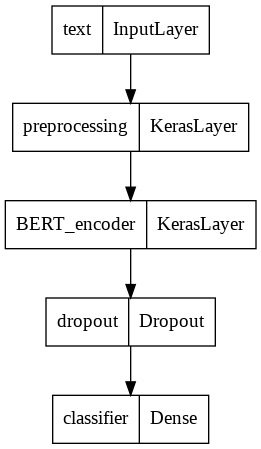

In [ ]:
tf.keras.utils.plot_model(classifier_model)

## Обучение модели

Теперь мы имеем все компоненты для обучения модели, включая модуль предварительной обработки, кодировщик BERT, данные и классификатор.

### Функция потерь

Для определения функции потерь будем использовать `losses.BinaryCrossentropy`

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Оптимизатор

Для точной настройки будем использовать тот же оптимизатор, который изначально обучал BERT: «Адаптивные моменты» (Адам). Этот оптимизатор минимизирует потери прогноза и выполняет регуляризацию по уменьшению веса (без использования моментов), которая также известна как [AdamW](https://arxiv.org/abs/1711.05101).

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Загрузка модели BERT и обучение

Используя `classifier_model`, который был создан ранее, скомпилируем модель с потерями, метрикой и оптимизатором.

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

ВНИМАНИЕ: время обучения зависит от сложности выбранной модели BERT.

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 177s 272ms/step - loss: 0.4821 - binary_accuracy: 0.7491 - val_loss: 0.3915 - val_binary_accuracy: 0.8310
Epoch 2/5
625/625 [==============================] - 158s 252ms/step - loss: 0.3313 - binary_accuracy: 0.8502 - val_loss: 0.3635 - val_binary_accuracy: 0.8426
Epoch 3/5
625/625 [==============================] - 156s 250ms/step - loss: 0.2504 - binary_accuracy: 0.8951 - val_loss: 0.3807 - val_binary_accuracy: 0.8516
Epoch 4/5
625/625 [==============================] - 156s 249ms/step - loss: 0.1975 - binary_accuracy: 0.9247 - val_loss: 0.4379 - val_binary_accuracy: 0.8492
Epoch 5/5
625/625 [==============================] - 156s 249ms/step - loss: 0.1575 - binary_accuracy: 0.9408 - val_loss: 0.4624 - val_binary_accuracy: 0.8510


### Оценка модели

Произведем оценку работы модели. Будут возвращены два значения:
* Потери (число, представляющее ошибку, чем меньше значения, тем лучше)
* Точность.

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 88s 112ms/step - loss: 0.4501 - binary_accuracy: 0.8563
Loss: 0.45013153553009033
Accuracy: 0.8562800288200378


### График точности и потерь с течением времени

На основе объекта `History`, возвращаемого `model.fit()`. Произведем построение графиков:
* потери при обучении и проверке для сравнения,
* точности обучения и проверки.

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


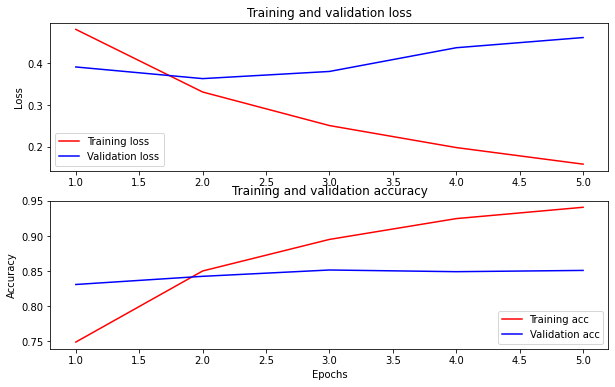

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r означает "сплошная красная линия".
plt.plot(epochs, loss, 'r', label='Training loss')
# b означает "сплошная синяя линия".
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

На этом графике красные линии представляют потери и точность обучения, а синие линии — потери и точность проверки.

Необходимо отметить отметить, что при обучении нейронной сети наблюдалась тенденция к переобучению, что требует использования особых методов регуляризации, или агументации данных, или более точного подбора гиперпараметров.

## Экспорт для вывода

Теперь можем сохранить доработанную модель для последующего использования.

In [ ]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

Произведем перезагрузку модели, для того чтобы была возможность попробовать ее с моделью, которая все еще находится в памяти.

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

Здесь можно протестировать модель на любом предложении, которое вы хотите, просто добавьте к переменной примеров ниже.

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # это то же самое предложение, которое было опробовано ранее
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999108
input: The movie was great!           : score: 0.994824
input: The movie was meh.             : score: 0.822603
input: The movie was okish.           : score: 0.052988
input: The movie was terrible...      : score: 0.001223

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999108
input: The movie was great!           : score: 0.994824
input: The movie was meh.             : score: 0.822603
input: The movie was okish.           : score: 0.052988
input: The movie was terrible...      : score: 0.001223



Если вы хотите использовать свою модель на [TF Serving](https://www.tensorflow.org/tfx/guide/serving), помните, что она будет вызывать вашу SavedModel через одну из своих именованных подписей. В Python вы можете протестировать их следующим образом

In [ ]:
serving_results = reloaded_model.signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.999108
input: The movie was great!           : score: 0.994824
input: The movie was meh.             : score: 0.822603
input: The movie was okish.           : score: 0.052988
input: The movie was terrible...      : score: 0.001223



# Текстовая классификация при помощи рекуррентных нейронных сетей

В данной части лекции произведем классификацию текстов при помощи [рекуррентных нейронных сетей](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network). Классификация будет производиться на [большом наборе данных обзоров фильмов](http://ai.stanford.edu/~amaas/data/sentiment/).

## Установка и настройка TensorFlow

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Импортируем `matplotlib` и опишем вспомогательную функцию для построения графиков:

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Настройка входного конвейера

Большой набор данных обзоров фильмов IMDB представляет собой набор данных бинарной классификации — все обзоры имеют либо положительные , либо отрицательные настроения.

Загрузка набора данных производится с помощью [TFDS](https://www.tensorflow.org/datasets). 

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteUEPI54/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteUEPI54/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteUEPI54/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Первоначально это возвращает набор данных (текст, пары меток):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Затем перетасуем данные для обучения и создадим группы этих (text, label) пар:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"This review may contain some SPOILERS.<br /><br />Just when you thought they didn't make them so extremely bad anymore, along comes Rae Dawn Chong as a space vixen and Willie Nelson as a Native American witchdoctor! It's even worse when you factor in that these two are the BETTER aspects of `Starlight,' a film that should only be viewed for laughs.<br /><br />Chong is an alien sent to Earth to seek out the only remaining half-breed, part man and part alien. Apparently, the Earth is in dire straits. Something is wrong with the genetics of mankind, and in a few decades the world will be turned into a polluted wasteland. Only by duplicating the DNA of the half-breed can the kindly alien race save the planet. Don't ask me how that is, since the movie gives the impression that the world will be destroyed by pollution, which is caused by humans. You would think Earth could only be saved by getting rid of the polluting creatures, not saving them! Anyway, the half-breed turns out to

## Создание кодировщика текста

Необработанный текст, загруженный с помощью, `tfds` должен быть обработан, прежде чем его можно будет использовать в модели. Самый простой способ обработки текста для обучения — использование `TextVectorization`.

Создадим слой и передадим текст набора данных в .adapt метод:

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Метод `.adapt` устанавливает словарный запас слоя. Вот первые 20 токенов. После заполнения и неизвестных токенов они сортируются по частоте:

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Как только словарь установлен, слой может кодировать текст в индексы. Тензоры индексов дополняются 0 до самой длинной последовательности в пакете (если не была произведена установка fixed в `output_sequence_length`):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11, 730, 194, ...,   0,   0,   0],
       [779,   2,   1, ...,   0,   0,   0],
       [ 48,  66,   4, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"This review may contain some SPOILERS.<br /><br />Just when you thought they didn't make them so extremely bad anymore, along comes Rae Dawn Chong as a space vixen and Willie Nelson as a Native American witchdoctor! It's even worse when you factor in that these two are the BETTER aspects of `Starlight,' a film that should only be viewed for laughs.<br /><br />Chong is an alien sent to Earth to seek out the only remaining half-breed, part man and part alien. Apparently, the Earth is in dire straits. Something is wrong with the genetics of mankind, and in a few decades the world will be turned into a polluted wasteland. Only by duplicating the DNA of the half-breed can the kindly alien race save the planet. Don't ask me how that is, since the movie gives the impression that the world will be destroyed by pollution, which is caused by humans. You would think Earth could only be saved by getting rid of the polluting creatures, not saving them! Anyway, the half-breed turns out 

## Создание модели

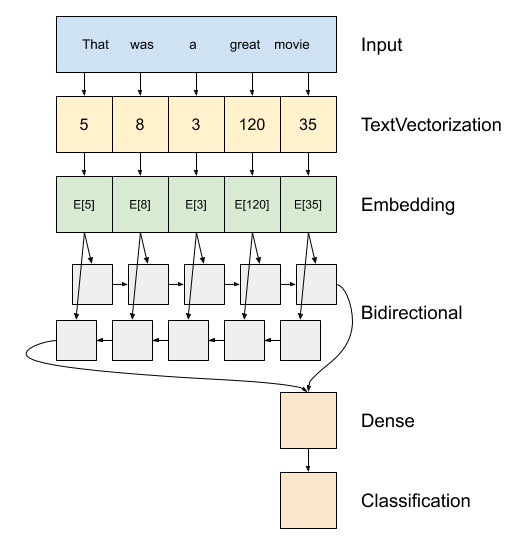

Выше представлена ​​схема модели.

* Эта модель может быть построена как `tf.keras.Sequential`.
* Первый слой — это `encoder`, который преобразует текст в последовательность индексов токенов.
* После кодировщика идет встраивающий слой. Слой внедрения хранит один вектор на слово. При вызове он преобразует последовательности индексов слов в последовательности векторов. Эти векторы поддаются обучению. После обучения (на достаточном количестве данных) слова со схожими значениями часто имеют схожие векторы.<br/>Этот поиск по индексу намного эффективнее, чем эквивалентная операция передачи горячего закодированного вектора через `tf.keras.layers.Dense` слой.

* Рекуррентная нейронная сеть (RNN) обрабатывает входную последовательность, перебирая элементы. RNN передают выходные данные с одного временного шага на вход следующего временного шага.<br/>Оболочку `tf.keras.layers.Bidirectional` также можно использовать со слоем RNN. Это распространяет ввод вперед и назад по уровню RNN, а затем объединяет окончательный вывод.

    * Основное преимущество двунаправленной RNN заключается в том, что сигнал с начала ввода не нужно обрабатывать на каждом временном шаге, чтобы повлиять на вывод.
    * Основным недостатком двунаправленной RNN является то, что вы не можете эффективно передавать предсказания, поскольку слова добавляются в конец.

* После того, как RNN преобразовала последовательность в один вектор, они layers.Denseвыполняют окончательную обработку и преобразуют это представление вектора в один логит в качестве результата классификации.

Код приведен ниже:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Используем маскировку для обработки переменных длин последовательностей
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Здесь важно Обратить внимание, на то что здесь используется последовательная модель Keras, поскольку все слои в модели имеют только один вход и производят один выход. Если необходимо использовать уровень RNN с отслеживанием состояния, то можно построить свою модель с помощью функционального API Keras или подкласса модели, чтобы была возможнлсть извлекать и повторно использовать состояния слоя RNN. Для более детального ознакомления можно почитать [следующий материал](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse).

Для обработки последовательнсотей различной длины слой встраивания использует [маскирование](https://www.tensorflow.org/guide/keras/masking_and_padding)
Слой встраивания использует маскирование для обработки различной длины последовательности. Все слои после встраивания поддерживают маскировку

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Чтобы убедиться, что это работает так, как ожидалось, оцените предложение дважды. Во-первых, в одиночку, чтобы не было отступов для маскировки:

In [ ]:
# предсказание по образцу текста без отступов.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.01906253]


Теперь произведем оценку еще раз в пакете с более длинным предложением. Результат должен быть идентичным:

In [ ]:
# предсказание на примере текста с отступами

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.01906253]


Скомпилируем модель Keras для настройки процесса обучения:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Обучение модели

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 42s 89ms/step - loss: 0.6335 - accuracy: 0.5744 - val_loss: 0.4859 - val_accuracy: 0.8000
Epoch 2/10
391/391 [==============================] - 32s 81ms/step - loss: 0.3928 - accuracy: 0.8203 - val_loss: 0.3906 - val_accuracy: 0.8036
Epoch 3/10
391/391 [==============================] - 32s 81ms/step - loss: 0.3409 - accuracy: 0.8508 - val_loss: 0.3431 - val_accuracy: 0.8531
Epoch 4/10
391/391 [==============================] - 32s 80ms/step - loss: 0.3204 - accuracy: 0.8611 - val_loss: 0.3319 - val_accuracy: 0.8516
Epoch 5/10
391/391 [==============================] - 32s 80ms/step - loss: 0.3143 - accuracy: 0.8633 - val_loss: 0.3262 - val_accuracy: 0.8562
Epoch 6/10
391/391 [==============================] - 32s 81ms/step - loss: 0.3085 - accuracy: 0.8681 - val_loss: 0.3340 - val_accuracy: 0.8562
Epoch 7/10
391/391 [==============================] - 33s 83ms/step - loss: 0.3055 - accuracy: 0.8696 - val_loss: 0.3253 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 47ms/step - loss: 0.3203 - accuracy: 0.8504
Test Loss: 0.3203398883342743
Test Accuracy: 0.8504400253295898


(0.0, 0.6502664402127266)

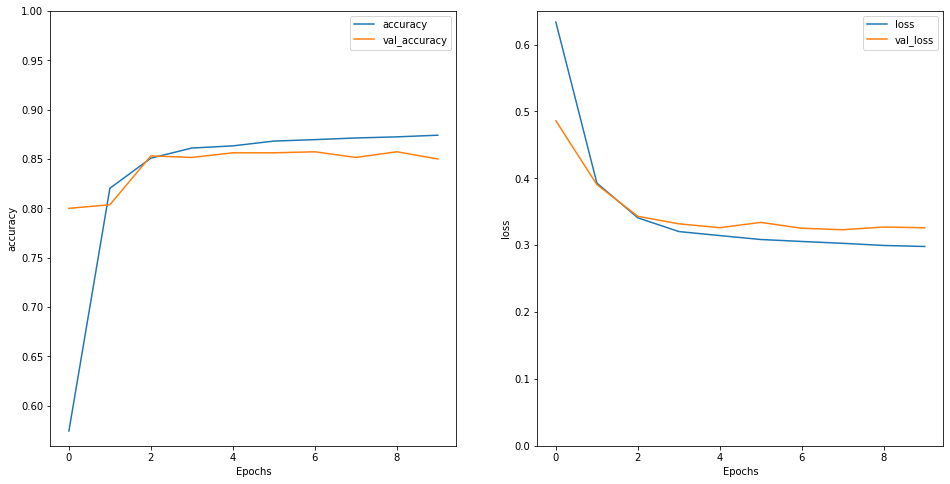

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Запустим процесс предсказания для нового предложения:

Если прогноз >= 0.0, то он положительный, в противном случае он отрицательный.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

## Стэк 2 или более слоев LSTM 

Если `False`, то он возвращает только последний вывод для каждой входной последовательности (двумерный тензор (`batch_size`, `output_features`)). Это значение по умолчанию, используемое в предыдущей модели.

Если `True`, то возвращаются полные последовательности последовательных выходных данных для каждого временного шага (трехмерный тензор (`batch_size`, `timesteps`, `output_features`)).

Вот как выглядит поток информации с `return_sequences=True`:

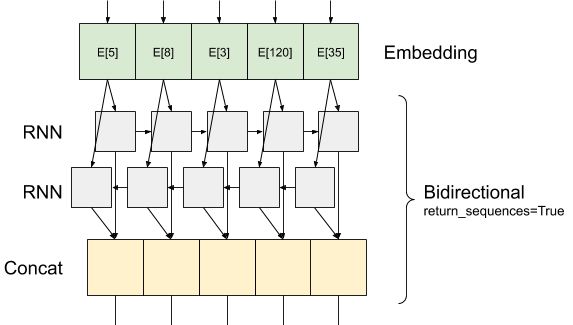

Интересная особенность использования `RNN` с `return_sequences=True` заключается в том, что выходные данные по-прежнему имеют 3 оси, как и входные, поэтому их можно передать на другой уровень RNN, например:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 71s 147ms/step - loss: 0.6745 - accuracy: 0.5165 - val_loss: 0.6111 - val_accuracy: 0.5870
Epoch 2/10
391/391 [==============================] - 53s 135ms/step - loss: 0.4857 - accuracy: 0.7679 - val_loss: 0.3989 - val_accuracy: 0.8297
Epoch 3/10
391/391 [==============================] - 53s 134ms/step - loss: 0.3817 - accuracy: 0.8364 - val_loss: 0.3574 - val_accuracy: 0.8490
Epoch 4/10
391/391 [==============================] - 54s 136ms/step - loss: 0.3394 - accuracy: 0.8544 - val_loss: 0.3364 - val_accuracy: 0.8578
Epoch 5/10
391/391 [==============================] - 53s 134ms/step - loss: 0.3222 - accuracy: 0.8629 - val_loss: 0.3329 - val_accuracy: 0.8406
Epoch 6/10
391/391 [==============================] - 55s 138ms/step - loss: 0.3144 - accuracy: 0.8664 - val_loss: 0.3248 - val_accuracy: 0.8594
Epoch 7/10
391/391 [==============================] - 54s 136ms/step - loss: 0.3089 - accuracy: 0.8676 - val_loss: 0.3214 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 28s 72ms/step - loss: 0.3160 - accuracy: 0.8592
Test Loss: 0.3160313367843628
Test Accuracy: 0.8592000007629395


In [ ]:
# предсказание по образцу текста без отступов.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-1.866885]]


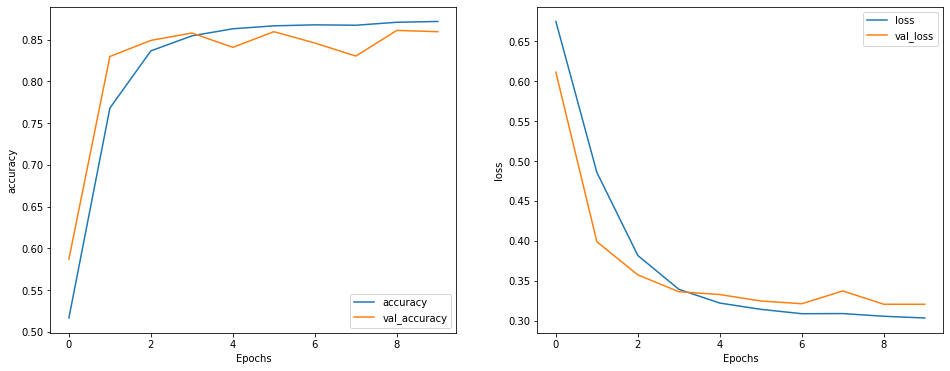

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Источники информации

Для подготовки данной лекции использовались следующие материалы
* Информация с официального сайта [TensorFlow](https://www.tensorflow.org/)
* Обработка текстовой информации на [TensorFlow](https://www.tensorflow.org/text)
    * при помощи модели BERT на [TensorFlow](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)
    * при помощи рекуррентых нейронных сетей на [TensorFlow](https://www.tensorflow.org/text/tutorials/text_classification_rnn)